# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [ ]:
data['survey'].head(3)

# Add DBN columns

In [42]:
data["hs_directory"].head(3)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162


In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

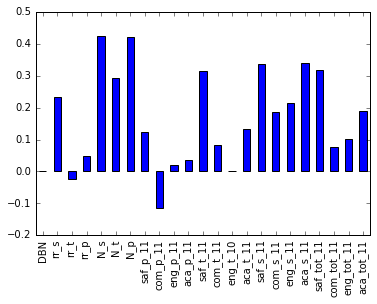

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

The correlations between sat_score and survey fields list were plotted. The observations are as follows:

1. Communication score based on parent responses have a light negative correlation with the actual SAT score. This is a bit surprising.

2. Safer schools tend to produce better students.

3. Student expectations are quite strongly correlated with their actual SAT scores.

It may, therefore make sense to explore this safety issue a bit further. All of three of Teacher, Student, Parent safety scores have strong positive correlations with SAT scores

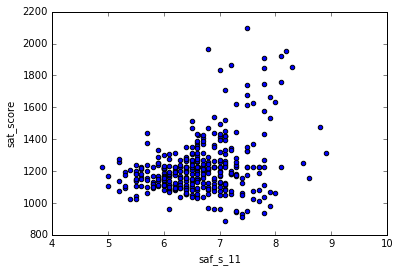

In [13]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

Let's assign weighted safety scores to the schools in our dataframe and then filter out the different districts by these average scores. A simple mean calculation will do.

In [14]:
combined['saf_avg_11'] = (combined['saf_s_11'] + combined['saf_t_11'] + combined['saf_p_11'])/3

In [15]:
import numpy as np

districts = combined.groupby('school_dist').agg(np.mean)

Plotting these schools on a map of NYC could help us understand any patterns better

In [16]:
from mpl_toolkits.basemap import Basemap

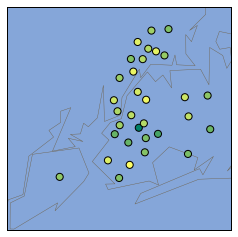

In [17]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, cmap = 'summer', c = districts['saf_avg_11'])

Upper Manhattan seems to be the most unsafe. Staten Island, parts of Queens and The Bronx are unsafe too. Brooklyn seems to be the safest area. Most yellow points to higher safety scores, and most green to lower.

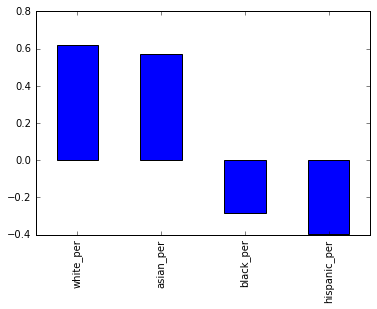

In [18]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][races].plot.bar()

Interesting. Plotting SAT scores across races indicicates strong positive correlations between white and asian kids. Black kids and Hispanic kids perform poorly, generally. Hispanic kids perform the poorest.

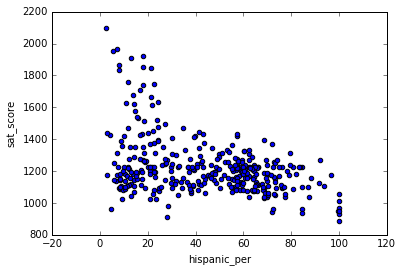

In [19]:
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

1. Schools with 100% Hispanic kids perform the poorest in the SAT. As the percentage shrinks, scores rise. This is a strong negative correlation, as we saw previously.

2. Schools with around 60% Hispanics tend to perform poorly, while schools with around 10-15% show mixed performance. The strong negative correlation is found in the middle percentages, i.e. 15-60%, where clearly scores fall as Hispanic percentages increase.

3. The schools with highest SAT scores have 0-5% Hispanic kids

It makes sense to therefore explore schools with a high percentage of Hispanic kids.

In [20]:
hispanic_majority = combined[combined['hispanic_per'] > 80]

In [21]:
hispanic_majority

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,saf_avg_11
31,02M427,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,0,0,0,0,0,"111 East 33Rd Street\nNew York, NY 10016\n(40....",40.746106,-73.981010,02,8.566667
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.000000,378.000000,344.000000,1058.000000,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,7.866667
80,06M293,CITY COLLEGE ACADEMY OF THE ARTS,60,408.000000,446.000000,416.000000,1270.000000,0,129.028846,197.038462,...,0,0,0,0,0,"4600 Broadway\nNew York, NY 10040\n(40.8611133...",40.861113,-73.930452,06,8.433333
81,06M346,COMMUNITY HEALTH ACADEMY OF THE HEIGHTS,55,362.000000,376.000000,367.000000,1105.000000,0,129.028846,197.038462,...,0,0,0,0,0,"504 West 158Th Street\nNew York, NY 10032\n(40...",40.833555,-73.941804,06,7.200000
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.000000,395.000000,399.000000,1174.000000,0,129.028846,197.038462,...,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06,8.266667
84,06M462,HIGH SCHOOL FOR INTERNATIONAL BUSINESS AND FIN...,76,365.000000,384.000000,378.000000,1127.000000,H.S. INT'L BUSINESS & FINANCE,108.000000,135.000000,...,0,0,0,0,0,"549 Audubon Avenue\nNew York, NY 10040\n(40.85...",40.855938,-73.927030,06,7.500000
85,06M463,HIGH SCHOOL FOR MEDIA AND COMMUNICATIONS,63,369.000000,380.000000,349.000000,1098.000000,H.S. MEDIA & COMMUNICATIONS,37.000000,64.000000,...,0,0,0,0,0,"549 Audubon Avenue\nNew York, NY 10040\n(40.85...",40.855938,-73.927030,06,7.266667
86,06M467,HIGH SCHOOL FOR LAW AND PUBLIC SERVICE,94,363.000000,378.000000,361.000000,1102.000000,H.S. LAW & PUBLIC SERVICE,141.000000,212.000000,...,0,0,0,0,0,"549 Audubon Avenue\nNew York, NY 10040\n(40.85...",40.855938,-73.927030,06,7.300000
87,06M468,HIGH SCHOOL FOR HEALTH CAREERS AND SCIENCES,24,400.000000,422.000000,402.000000,1224.000000,H.S. HEALTH CAREERS & SCIENCE,32.000000,38.000000,...,0,0,0,0,0,"549 Audubon Avenue\nNew York, NY 10040\n(40.85...",40.855938,-73.927030,06,7.233333
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.000000,349.000000,326.000000,1014.000000,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06,8.466667


1. What's interesting is that schools with more than 80% Hispanic kids have medium-high to high safety!

2. Most of these schools are attended by recent immigrants, who may be new to the English language, the math curriculum, and may not have yet developed adequate reading skills.

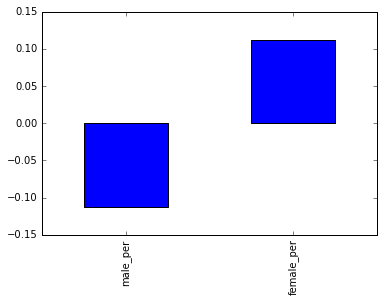

In [22]:
gender = ['male_per', 'female_per']

combined.corr()['sat_score'][gender].plot.bar()

There is quite a weak positive and negative correlation for males and females when it comes to SAT scores. Girl heavy schools tend to perform only slightly better.

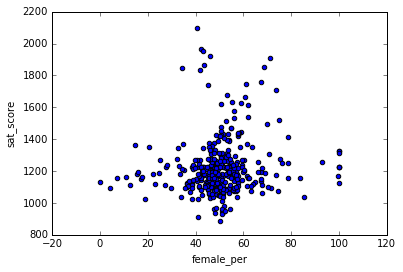

In [23]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')

As discussed previously, there is no strong correlation on either side. 

1. Schools with approximately equal boys and girls tend not to score well on the SAT. Scores range from 900 to 1400 (Approx.)

2. Schools with 30-40% girls perform very well, in the range of 1700-2100 (Approx.)

3. Schools with 60-80% girls perform decently in the range of 1600-2000 (Approx.)

In [24]:
#Let's calculate the percentage of AP takers in every school

combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment']) * 100

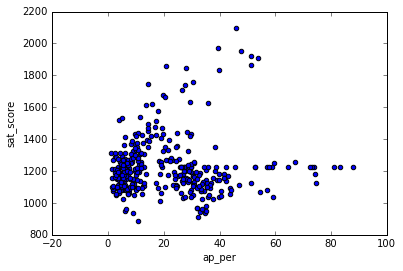

In [25]:
combined.plot.scatter(x = 'ap_per', y = 'sat_score')

(Counterintuitively?) There appears to be no strong correlation betwen SAT scores and AP test takers. A slight relationship may be discernible, but that would certainly not amount to any statistical significance. 

The AP Test and the SAT may therefore be quite independent (The AP may require quite an advanced domain knowledge. This can explain a situation where a student who's done well in the SAT but hasn't in the AP, and another who's done well in the AP, and therefore done well in the easier SAT).

In [26]:
combined.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,saf_avg_11,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,6.700000,30.575556
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,6.833333,9.898477
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,7.537222,3.177258


In [27]:
#Let's look at the best performing districts

combined['school_dist'].value_counts()

02    48
10    22
09    20
11    15
17    14
14    14
07    13
24    13
13    13
12    12
03    12
19    12
28    11
21    11
08    11
18    11
06    10
27    10
31    10
15     9
30     9
25     8
29     8
05     7
04     7
32     6
01     6
20     5
26     5
22     4
16     4
23     3
Name: school_dist, dtype: int64

In [28]:
districts.head(3)

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,saf_avg_11
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377,7.356204
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386,7.522998
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370,7.236111


In [29]:
districts.reset_index(inplace = True)

In [30]:
districts.head(3)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,saf_avg_11
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377,7.356204
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386,7.522998
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370,7.236111


In [31]:
districts.describe()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,saf_avg_11
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.0,32.000000,32.000000,32.000000,32.0,32.0,32.0,32.000000,32.000000,32.000000
mean,404.860496,422.458600,400.320914,1227.640010,138.633066,210.172031,160.903991,223.991434,16.500000,192.799961,...,12.0,10852.590993,882.770004,1.959172,0.0,0.0,0.0,40.728794,-73.918258,7.282910
std,28.862200,37.648049,29.953385,95.260356,85.149677,135.427289,72.300531,172.845575,9.380832,124.144097,...,0.0,532.636128,632.053589,0.988563,0.0,0.0,0.0,0.081391,0.075965,0.322172
min,364.769900,373.090909,357.943781,1101.823134,29.000000,31.000000,83.558333,72.771261,1.000000,72.209438,...,12.0,10003.166667,344.000000,1.000000,0.0,0.0,0.0,40.593596,-74.125726,6.333333
25%,381.675622,394.417857,377.977001,1159.082180,85.245261,124.198077,115.161538,111.877880,8.750000,118.895882,...,12.0,10455.248077,472.055288,1.293182,0.0,0.0,0.0,40.674126,-73.960981,7.088095
50%,399.039979,417.142857,392.297927,1214.269946,117.530230,170.520105,147.883766,159.983016,16.500000,137.374514,...,12.0,11207.326923,615.626488,1.654762,0.0,0.0,0.0,40.715311,-73.924829,7.275583
75%,427.502399,449.572528,425.353545,1293.991822,156.445580,246.422810,174.929403,270.388380,24.250000,230.858376,...,12.0,11221.500000,1078.568182,2.235577,0.0,0.0,0.0,40.799290,-73.885749,7.523498
max,473.500000,502.750000,474.250000,1450.500000,410.605769,632.407692,392.090000,825.600000,32.000000,595.953216,...,12.0,11556.300000,2837.400000,5.000000,0.0,0.0,0.0,40.873138,-73.752740,7.833333


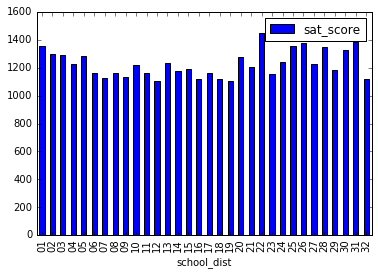

In [32]:
districts.plot.bar(x = 'school_dist', y = 'sat_score')

Districts 31 and 22 seem to have the highest mean SAT scores. Let's explore these two a bit more

In [33]:
district_31 = districts[districts['school_dist'] == '31']

print(district_31['hispanic_per']) # Percentage Hispanic kids
print(district_31['black_per']) # Percentage of Black kids
print(district_31['asian_per']) # Percentage of Black kids
print(district_31['female_per']) # Percentage of girls
print(district_31['Total Cohort']) # Class size

30    22.17
Name: hispanic_per, dtype: float64
30    18.27
Name: black_per, dtype: float64
30    10.3
Name: asian_per, dtype: float64
30    47.91
Name: female_per, dtype: float64
30    450.787097
Name: Total Cohort, dtype: float64


In [34]:
district_22 = districts[districts['school_dist'] == '22']

print(district_22['hispanic_per'])
print(district_22['black_per']) 
print(district_22['asian_per']) # Percentage of Black kids
print(district_22['female_per'])
print(district_22['Total Cohort'])

21    12.35
Name: hispanic_per, dtype: float64
21    35.1
Name: black_per, dtype: float64
21    17.975
Name: asian_per, dtype: float64
21    55.7
Name: female_per, dtype: float64
21    580.25
Name: Total Cohort, dtype: float64


The top 2 schools have excellent representation of girls and other racial backgrounds. Let's see if this extends to the top 5 districts! 

In [35]:
#We calculate the mean percentage of girls in top 5 districts

top_districts = districts.sort_values(by = 'sat_score', ascending = False)
top_districts = top_districts.iloc[0:5]
top_districts['female_per'].mean()

51.167999999999999

Wow! The best performing schools have nearly an equal number of boys and girls. Great going!
Now let's analyze the racial diversity in these schools. To do that, we'll make a separate column that adds up the percentages of Asians, Blacks, and Hispanics in these districts.

In [36]:
top_districts['racial_per'] = top_districts['black_per'] + top_districts['asian_per'] + top_districts['hispanic_per']
top_districts['racial_per'].mean()

73.117666666666665

Another excellent bit of news. The best performing schools have huge racial diversities. This indicates that, while heavily Hispanic/Black schools perform poorly, in a mixed environment, performance improves [As should be the case. A variety of people helping each other out!]

0.325144024007


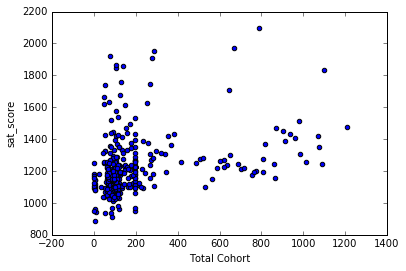

In [37]:
combined.plot.scatter(x = 'Total Cohort', y = 'sat_score')
print(combined.corr()['sat_score']['Total Cohort'])

1. We find a weak but positive correlation between SATs and class sizes, but certainly not a significant relationship.

2. However, one observation is that once that class sizes grow in number, scores tend to rise a bit more significantly. This rise is much more significant in the range of class sizes of 600-1400 than in the lower ranges.

3. Having said that, there are quite a few high scores in smaller classes [0 - 200]

In [38]:
combined.head(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,saf_avg_11,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,6.700000,30.575556
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,6.833333,9.898477
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,7.537222,3.177258


As a final analysis, let's figure out the best area to live in if one is searching for schools in NYC. 3 metrics have been considered to be the most important:

1. SAT scores. [Duh!]

2. Safety: Since this has been found to be strongly correlated to performance, we will exclude it from our analysis.

3. Gender inclusion: Since this metric hasn't been found to be strongly indicative of performance, we will exclude this too.

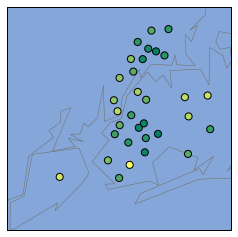

In [39]:
area = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

area.drawmapboundary(fill_color='#85A6D9')
area.drawcoastlines(color='#6D5F47', linewidth=.4)
area.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

area.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, cmap = 'summer', c = districts['sat_score'])

1. Upper Manhattan and The Bronx would not be advised.

2. Lower Manhattan can boast of decent schools. 

3. Brooklyn, though found the safest burrough, does not produce great results, with only 1 district shining. Lower Manhattan does not have incredible scores, but all scores are on average higher than Brooklyn.

4. Staten Island has one district that shines, although that was the only district available in the data set. Therfore, not very informative.

In short, Lower Manhattan would be advised, although choosing an area of course would depend on many more features like tuition, price of property, etc.

# Let us sum up our findings:

1. Safer schools tend to produce better scores.

2. Student expectations are quite strongly correlated with their actual SAT scores. 

3. Upper Manhattan seems to be the most unsafe. Staten Island, parts of Queens and The Bronx are unsafe too. Brooklyn seems to be the safest area.

4. The top 5 districts have nearly an equal representation of boys and girls, and impressive representations of minorities [More than 60% on average]. This indicates the worse performing schools may need to evaluate how inclusive their curricula are, especially since heavily Hispanic schools tend to perform the worst on the SAT.

5. Girl heavy schools [> 60% ratio] tend to perform better on the SAT. Boy heavy schools [> 70% ratio] tend to perform the worst. A girl-to-boy ratio of around 55-40 seems ideal.

6. The AP scores are majorly independent of SAT scores.

7. The best performing region has been found to be Lower Manhattan in terms of SAT scores. Brooklyn also does well.